## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [40]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
from math import log2
import numpy as np

def gini(sequence):

    _, count = np.unique(sequence, return_counts=True)
    p = count / len(sequence)
    sumPj = np.sum(p ** 2)
    return 1 - sumPj

def entropy(sequence):

    _, count = np.unique(sequence, return_counts=True)
    p = count / len(sequence)
    sumPlogP = np.sum(p * np.log2(p))
    return -sumPlogP
    

In [41]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [42]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [43]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [44]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)

train_df.head()

(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the criterionValue of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [45]:
x_train = train_df.drop(['price_range'], axis="columns").values
y_train = train_df['price_range'].values

x_val = val_df.drop(['price_range'], axis="columns").values
y_val = val_df['price_range'].values

In [75]:
import random

class Node():
    def __init__(self, index=None, threshold=None, left=None, right=None, criterionValue=None, leafValue=None):
        self.index = index # decision node
        self.threshold = threshold
        self.left = left
        self.right = right
        self.criterionValue = criterionValue
        self.leafValue = leafValue # leaf node


class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None):
        self.criterion = criterion
        self.max_depth = max_depth # stopping conditions
        self.max_features = max_features # * for random forest *
        self.root = None
        self.depth = 0
        self.featureCount = 0 # how many features
        self.used = None # the features used

    def fit(self, x_data, y_data):

        self.featureCount = x_data.shape[1]
        # combine the data
        y_data = y_data.reshape(-1, 1)
        data = np.concatenate((x_data, y_data), axis=1)
        self.root = self.build(data)

    def build(self, data, depth=1):

        x_data, y_data = data[:, :-1], data[:, -1]
        sample, feature = np.shape(x_data)

        # * for random forest, set the feature number to maximum features *
        if self.max_features is not None:
            feature = self.max_features

        if self.max_depth is None:
            self.max_depth = sample

        # split until stopping condition
        if depth <= self.max_depth:
            # find the best split
            bestSplits = self.bestSplit(data, feature)
            
            # can further split
            if len(bestSplits) != 0:
                if bestSplits["criterionValue"] > 0:
                    l = self.build(bestSplits["left"], depth+1)
                    r = self.build(bestSplits["right"], depth+1)
                    # return decision node
                    return Node(bestSplits["index"], bestSplits["threshold"], l, r, bestSplits["criterionValue"])

        # return leaf node
        return Node(leafValue=max(list(y_data), key=list(y_data).count))

    def bestSplit(self, data, feature):
        
        bestSplits = {} # store the stuff for the best split
        bestCriterionValue = -float("inf")

        if feature == self.featureCount:
            featureIndex = [i for i in range(self.featureCount)]
        else:
            # * for random forest *
            featureIndex = random.sample(range(self.featureCount), feature)

        # loop over all the features
        for index in featureIndex:
            featureValue = data[:, index]
            candidate = np.unique(featureValue)
            bestCriterionAttribute = []
            for i in range(len(candidate)-1):
                chosen = (candidate[i] + candidate[i+1]) / 2
                bestCriterionAttribute.append(chosen) # take the median

            # for all features
            for attr in bestCriterionAttribute:
                # get current split
                left = np.array([row for row in data if row[index] <= attr])
                right = np.array([row for row in data if row[index] > attr])

                # if both have child
                if len(left) > 0 and len(right) > 0:
                    node = data[:, -1]
                    l, r = left[:, -1], right[:, -1]

                    # calculate the weighted information gain
                    weight_l = len(l) / len(node)
                    weight_r = len(r) / len(node)
                    if self.criterion == "gini":
                        value = gini(node) - (weight_l * gini(l) + weight_r * gini(r))
                    else:
                        value = entropy(node) - (weight_l * entropy(l) + weight_r * entropy(r))
                        
                    # update the best criterion value    
                    if value > bestCriterionValue:
                        bestSplits["index"] = index
                        bestSplits["threshold"] = attr
                        bestSplits["left"] = left
                        bestSplits["right"] = right
                        bestSplits["criterionValue"] = value
                        bestCriterionValue = value

        # return best split
        return bestSplits

    def predict(self, x_data):

        # predict for each data
        preditions = [self.prediction(x, self.root) for x in x_data]
        return preditions

    def prediction(self, x_data, tree):

        # it's a leaf
        if tree.leafValue is not None: 
            return tree.leafValue

        # if not, go deeper
        if x_data[tree.index] <= tree.threshold: 
            return self.prediction(x_data, tree.left)
        else:
            return self.prediction(x_data, tree.right)

    def Importance(self): # * for plotting *

        self.used = np.zeros(self.featureCount)
        self.traverse(self.root)

        return self.used

    def traverse(self, node): # * for plotting *

        if node.left and node.left.criterionValue is not None:
            self.traverse(node.left)
        if node.right and node.right.criterionValue is not None:
            self.traverse(node.right)
            
        self.used[node.index] += 1

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [52]:
def accuracy(pred, val):
    pred = np.array(pred)
    val = np.array(val)
    return np.sum(pred == val)/len(val)

clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_train, y_train)
y_pred = clf_depth3.predict(x_val)
print("Decision Tree (criterion=gini, max_depth=3) accuracy:", accuracy(y_pred, y_val))

clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_train, y_train)
y_pred = clf_depth10.predict(x_val)
print("Decision Tree (criterion=gini, max_depth=10) accuracy:", accuracy(y_pred, y_val))


Decision Tree (criterion=gini, max_depth=3) accuracy: 0.92
Decision Tree (criterion=gini, max_depth=10) accuracy: 0.94


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [49]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x_train, y_train)
y_pred = clf_gini.predict(x_val)
print("Decision Tree (criterion=gini, max_depth=3) accuracy:", accuracy(y_pred, y_val))

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_train, y_train)
y_pred = clf_entropy.predict(x_val)
print("Decision Tree (criterion=gini, max_depth=10) accuracy:", accuracy(y_pred, y_val))

Decision Tree (criterion=gini, max_depth=3) accuracy: 0.92
Decision Tree (criterion=gini, max_depth=10) accuracy: 0.9333333333333333


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

Text(0.5, 1.0, 'Feature Importance')

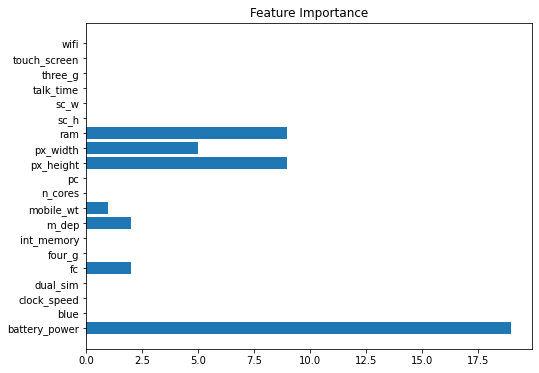

In [58]:
import matplotlib.pyplot as plt
f = clf_depth10.Importance()
feature_names = list(train_df.columns)
feature_names.pop()  # Pop the "target column"

plt.figure(figsize=(8, 6))
plt.barh(feature_names, f)
plt.title("Feature Importance")

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [87]:

class AdaBoost():
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.predicts = [] # for predictors weights

    def fit(self, x_data, y_data):
        
        sample, feature = x_data.shape
        self.x_data = x_data
        self.y_data = y_data

        x = self.x_data # for fitting
        y = self.y_data

        signedY = y_data.copy()
        signedY[y_data == 0] = -1

        # uniform weight distribution
        sampleWeight = np.full(sample, 1/sample)

        for epoch in range(self.n_estimators):

            # train the weak classifiers
            weak_clf = DecisionTree(criterion='gini', max_depth=1)
            weak_clf.fit(x, y)
            y_pred = weak_clf.predict(self.x_data)
            for i in range(len(y_pred)): # change the range from 0 and 1 to -1 and 1
                if y_pred[i] == 0:
                    y_pred[i] = -1

            # minimize the weighted error
            error = np.sum(sampleWeight[y_pred != signedY])

            # calculate the weight classifier alpha
            alpha = (1/2) * np.log((1 - error) / (error))

            # record the classifier and alpha
            self.predicts.append((weak_clf, alpha))

            # update distribution by -1 * alpha * y_pred * y_data
            for i in range(len(sampleWeight)):
                sampleWeight[i] = sampleWeight[i] * np.exp(-1 * alpha * y_pred[i] * signedY[i])
                sampleWeight[i] = sampleWeight[i]/ np.sum(sampleWeight) # normalize
            sampleWeight = np.array(sampleWeight)

            # resample with the new weights
            data = [i for i in range(len(x_data))]
            idx = random.choices(data, weights=sampleWeight, k=len(sampleWeight))
            x = self.x_data[idx]
            y = self.y_data[idx]

    def predict(self, x_data):

        prediction = np.array([clf.predict(x_data) for clf, alpha in self.predicts])
        predictions = np.zeros(len(x_data)) # final prediction

        for i in range(len(self.predicts)):
            y_pred = np.array(self.predicts[i][0].predict(x_data))
            y_pred[y_pred == 0] = -1
            predictions += self.predicts[i][1] * y_pred # strong classifier

        predictions = np.sign(predictions)
        predictions[predictions < 0] = 0
        return predictions

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [60]:
clf_adaboost_10 = AdaBoost(n_estimators=10)
clf_adaboost_10.fit(x_train, y_train)
y_pred = clf_adaboost_10.predict(x_val)
print("AdaBoost (n_estimators=10) accuracy:", accuracy(y_pred, y_val))

clf_adaboost_100 = AdaBoost(n_estimators=100)
clf_adaboost_100.fit(x_train, y_train)
y_pred = clf_adaboost_100.predict(x_val)
print("AdaBoost (n_estimators=100) accuracy:", accuracy(y_pred, y_val))

AdaBoost (n_estimators=10) accuracy: 0.9433333333333334
AdaBoost (n_estimators=100) accuracy: 0.9766666666666667


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [96]:
from collections import Counter

class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = int(max_features)
        self.bootstrap = boostrap
        self.criterion = criterion
        self.tree = [] # for storing the classifiers and the chosen feature

    def fit(self, x_data, y_data):
        
        for epoch in range(self.n_estimators):

            # implement a tree for each epoch
            tree = DecisionTree(criterion=self.criterion, max_depth = self.max_depth, max_features=self.max_features)
            
            if self.bootstrap:
                used = np.random.choice(x_data.shape[0],  x_data.shape[0], replace=True)
                x_sample, y_sample = x_data[used], y_data[used]
            else:
                x_sample, y_sample = x_data, y_data

            # train with the chosen data
            tree.fit(x_sample, y_sample)
            self.tree.append(tree)

    def predict(self, x_data):
        
        prediction = np.array([tree.predict(x_data) for tree in self.tree])
        prediction = np.swapaxes(prediction, 0, 1)

        # vote for the class which is often predicted
        y_pred = [Counter(predict).most_common(1)[0][0] for predict in prediction]
        return y_pred

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [91]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_10tree.fit(x_train, y_train)
y_pred = clf_10tree.predict(x_val)
print("Random Forest (n_estimators=10) accuracy:", accuracy(y_pred, y_val))

clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))
clf_100tree.fit(x_train, y_train)
y_pred = clf_100tree.predict(x_val)
print("Random Forest (n_estimators=100) accuracy:", accuracy(y_pred, y_val))

IndexError: index 618 is out of bounds for axis 0 with size 4

### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [81]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_random_features.fit(x_train, y_train)
y_pred = clf_random_features.predict(x_val)
print("Random Forest (max_features = sqrt(n_features)) accuracy:", accuracy(y_pred, y_val))

clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_all_features.fit(x_train, y_train)
y_pred = clf_all_features.predict(x_val)
print("Random Forest (max_features = n_features) accuracy:", accuracy(y_pred, y_val))

Random Forest (max_features = sqrt(n_features)) accuracy: 0.48
Random Forest (max_features = n_features) accuracy: 0.5


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [88]:
def train_your_model(data):
    
    x_train = train_df.drop(['price_range'], axis="columns").values
    y_train = train_df['price_range'].values

    model = None
    max_accuracy = 0

    # Decision Tree maximum accuracy = 0.936
    # model = DecisionTree(criterion='gini', max_depth=100)
    # model.fit(x_train, y_train)

    # AdaBoost maximum accuracy = 0.963
    model = AdaBoost(n_estimators=200)
    model.fit(x_train, y_train)

    # Random Forest maximum accuracy = 0.963
    # model = RandomForest(n_estimators=100, max_depth=30, max_features=x_train.shape[1])
    # model.fit(x_train, y_train)

    return model


In [89]:
my_model = train_your_model(train_df)
y_pred = my_model.predict(x_val)
print("Accuracy of tuned-model: ", accuracy(y_pred, y_val))

# train with train and validation dataset
finalTrain_df = pd.concat([train_df, val_df])
my_model = train_your_model(finalTrain_df)

Accuracy of tuned-model:  0.9766666666666667


In [ ]:
y_pred = my_model.predict(x_test)

NameError: name 'x_test' is not defined

In [ ]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [94]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'y_test.csv'

In [97]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
